In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

warnings.filterwarnings('ignore')
path = '../GKX/'
### Data preparation
## Load 94 firm characteristics dataset
data_ch = pd.read_csv(path+'GKX_20201231.csv')
data_ch['DATE'] = pd.to_datetime(data_ch['DATE'], format='%Y%m%d') + pd.offsets.MonthEnd(0)
data_ch = data_ch[(data_ch['DATE'] >= '1957-01-31') & (data_ch['DATE'] <= '2016-12-31')]
cols = data_ch.columns.tolist()
cols_new = [x for x in cols if x not in ['permno', 'prc', 'SHROUT', 'mve0']]
data_ch = data_ch[cols_new]


# Construct dummy variables
# Remove the samples with missing 'sic2'
data_ch  = data_ch.dropna(subset=['sic2']).reset_index(drop=True)
dummies = pd.get_dummies(data_ch['sic2'], prefix='dum_')
data_ch = data_ch.drop('sic2', axis=1)
data_ch = pd.concat([data_ch, dummies], axis=1)


# Replace all missings of firm characteristics with 0
chas = [x for x in cols_new if x not in ['DATE', 'RET', 'sic2']]
data_ch[chas] = data_ch[chas].fillna(0)

## Load 8 macroeconomic predictors
data_ma = pd.read_csv(path+'PredictorData2023.csv')
data_ma['yyyymm'] = pd.to_datetime(data_ma['yyyymm'], format='%Y%m') + pd.offsets.MonthEnd(0)
data_ma = data_ma[(data_ma['yyyymm'] >= '1957-01-31') & (data_ma['yyyymm'] <= '2016-12-31')].reset_index(drop=True)
#data_ma

# Construct 8 macroeconomic predictors
ma_predictors = ['dp', 'ep', 'bm', 'ntis', 'tbl', 'tms', 'dfy', 'svar']
data_ma['Index'] = data_ma['Index'].str.replace(',', '').astype('float64')
data_ma['dp'] = np.log(data_ma['D12'] / data_ma['Index'])
data_ma['ep'] = np.log(data_ma['E12'] / data_ma['Index'])
data_ma.rename(columns={'b/m': 'bm'}, inplace=True)
data_ma['tms'] = data_ma['lty'] - data_ma['tbl']
data_ma['dfy'] = data_ma['BAA'] - data_ma['AAA']
data_ma = data_ma[['yyyymm'] + ma_predictors]

# Construct the dataset including all covariates
data_ma_long = pd.merge(data_ch['DATE'], data_ma, left_on='DATE', right_on='yyyymm', how='left').drop('yyyymm', axis=1)
for cha in chas:
    for predictor in ma_predictors:
        name = cha + '_' + predictor
        data_ch[name] = data_ch[cha] * data_ma_long[predictor]
data = data_ch

# # concate without covariates
# data = pd.merge(data_ch, data_ma, left_on='DATE', right_on='yyyymm', how='left').drop('yyyymm', axis=1)
## Split the dataset
def get_data_split(str, end):
    # covariates = list(set(data.columns).difference({'DATE','RET'}))
    # X = data[(data['DATE'] >= str) & (data['DATE'] <= end)][covariates].values
    ch = list(set(data.columns).difference({'DATE','RET'}))
    X = data[(data['DATE'] >= str) & (data['DATE'] <= end)][ch].to_numpy()
    y = data[(data['DATE'] >= str) & (data['DATE'] <= end)]['RET'].to_numpy()
    return X, y

def r2_score(y, yhat):
    r2 = 1 - sum((y - yhat) ** 2) / sum(y ** 2)
    return r2

init_train_str = '1957-01-31'; init_train_end = '1974-12-31'
init_val_str = '1975-01-31'; init_val_end = '1986-12-31'
init_test_str = '1987-01-31'; init_test_end = '2016-12-31'
year_span = 30

In [ ]:
### Model Fit
pls_oos_r2 = []
pls_para = []
for i in range(year_span):
    # Get training dataset, test dataset split, test for one year
    train_str = pd.to_datetime(init_train_str)
    train_end = pd.to_datetime(init_train_end)+pd.DateOffset(years=i)
    val_str = train_end + pd.DateOffset(years=1)
    val_end = pd.to_datetime(init_val_end)+pd.DateOffset(years=i)
    oos_str = val_end + pd.DateOffset(years=1)
    oos_end = oos_str

    x_train, y_train = get_data_split(train_str, train_end)
    x_val, y_val = get_data_split(val_str, val_end)
    x_test, y_test = get_data_split(oos_str, oos_end)

    best_r2 = -np.inf
    best_K = 0
    # Fit model and choose best parameters
    for K in range(1,5,1):
        pls = PLSRegression(n_components=K)
        pls_model = make_pipeline(StandardScaler(), pls)
        pls_model.fit(x_train, y_train)
        y_val_hat = pls_model.predict(x_val).flatten()
        val_r2= r2_score(y_val,y_val_hat)
        if val_r2>best_r2:
            best_r2 = val_r2
            best_K = K

    pls_para.append(best_K)
    pls = PLSRegression(n_components=best_K)
    pls_model = make_pipeline(StandardScaler(), pls)
    pls_model.fit(x_train, y_train)
    y_test_hat = pls_model.predict(x_test).flatten()
    oos_r2 = r2_score(y_test,y_test_hat)
    pls_oos_r2.append(oos_r2)
    print("year:{0}/30, r^2:{1}, K:{2}".format(i+1,oos_r2,best_K))

In [244]:
pls_rec = pd.DataFrame({'r^2':pls_oos_r2,'K':pls_para})
pls_rec.to_csv("pls.csv",index=False,sep=',')
with open("./chas.txt",'w') as f:
    _chs = data.columns.values.tolist()
    _chs.remove('DATE')
    _chs.remove('RET')
    f.write(",".join(_chs)+'\n')

### Plot $R^2$ and Best component

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plsdata = pd.read_csv("./pls.csv")

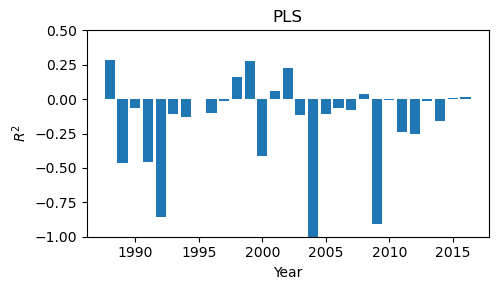

In [9]:
plt.figure(figsize=(5,3))
plt.title("PLS")
plt.xlabel('Year')
plt.ylim(-1.,0.5)
plt.ylabel('$R^2$')
plt.bar(np.arange(1988,2017),plsdata['r^2'][1:])
plt.tight_layout()

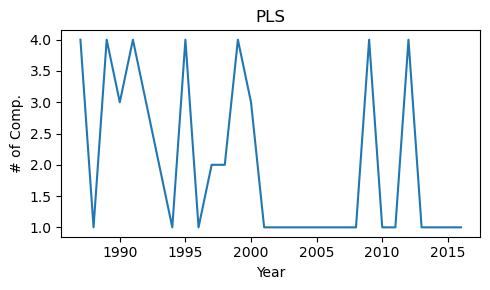

In [10]:
plt.figure(figsize=(5,3))
plt.title("PLS")
plt.xlabel('Year')
plt.ylabel('# of Comp.')
plt.plot(np.arange(1987,2017),plsdata['K'])
plt.tight_layout()

### Variable Importance

In [13]:
from sklearn.inspection import permutation_importance
import pandas as pd

init_train_str = '1957-01-31'; init_train_end = '1974-12-31'
init_val_str = '1975-01-31'; init_val_end = '1986-12-31'
init_test_str = '1987-01-31'; init_test_end = '2016-12-31'
year_span = 30

train_str = pd.to_datetime(init_train_str)
train_end = pd.to_datetime(init_val_end)+pd.DateOffset(years=year_span)
oos_str = train_end+pd.DateOffset(years=1)
oos_end = oos_str
x_train, y_train = get_data_split(train_str, train_end)
x_test, y_test = get_data_split(oos_str, oos_end)

plsdata = pd.read_csv("./pls.csv")
K = plsdata['K'].values[-1]
pls = PLSRegression(n_components=K)
pls_model = make_pipeline(StandardScaler(), pls)
pls_model.fit(x_train,y_train)

results = permutation_importance(pls_model,x_train,y_train,n_repeats=2,random_state=421)

In [36]:
np.savetxt("importance.txt",results['importances'])
np.savetxt("importance_mean.txt",results['importances_mean'])
np.savetxt("importance_std.txt",results['importances_std'])

In [38]:
chas = pd.read_table('./chas.txt',header=None,sep=',')
vi = pd.DataFrame({'chas':chas.values[0],'val':results['importances_mean'].flatten()})
vi.to_csv("pls_vi.csv",index=False,sep=',')

### Plot the Variable Importance: 20

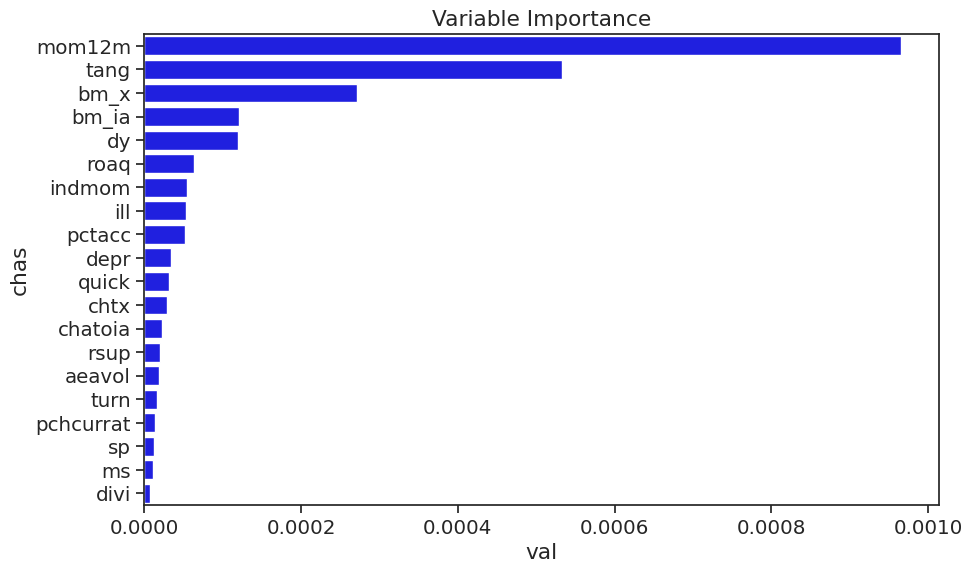

In [82]:
import seaborn as sns
pls_vi = pd.read_csv("pls_vi.csv")
# delete sic_dummy
pls_vi = pls_vi[~pls_vi['chas'].str.contains('dum__')]
vi20=pls_vi.sort_values(by="val",ascending=False)[0:20]
vi20.to_csv("pls_vi_20.csv",index=False,sep=',')

plt.figure(100,figsize=(10,6))
ax = sns.barplot(x=vi20['val'],y=vi20['chas'],color='blue')
ax.set_title('Variable Importance')
sns.set(context='notebook', style='ticks', font_scale=1.3,)
# ax.legend(title = 'Variable Importance', fontsize = 14, title_fontsize = 14)
plt.tight_layout()